In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
import numpy as np
import ipywidgets as widget

from numpy import cos, sin
import subprocess
import os

- Написать программу, которая рисует единичный куб позволяет вращать его вокруг локальных осей 𝑂𝑥 и 𝑂𝑦,
перемещать (транслировать) в любом направлении, а затем проецировать одноточечной или двуточечной
перспективной проекцией на плоскость $𝑂_{𝑥𝑦}$.
- Создать, на выбор, или анимацию, в которой куб будет перемещаться и вращаться отображаясь при этом
в перспективной проекции, или использовать несколько ползунков, которыми можно будет задавать углы
поворотов и смещение по осям для задания трансляции. Изображение с кубом при этом должно перерисо-
вываться

In [2]:
outDir = "frames"
FFMPEG = 'ffmpeg'
frames = 60
CMD = [FFMPEG, '-y', '-r', '1', '-f', 'image2', '-i', f'{outDir}/frame_%03d.png',
       '-vcodec', 'libx264', '-crf', '25', '-pix_fmt', 'yuv420p', 'cube in projection.mp4']
print(' '.join(CMD))

def animate():
    subprocess.run(CMD)

ffmpeg -y -r 1 -f image2 -i frames/frame_%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p cube in projection.mp4


In [8]:
p,q,r = 0.1, 0.1,-0.25
n = 3
dx,dy,dz = 0, 2, -1
theta_x = np.linspace(0, 2 * np.pi * n, frames)
theta_y = np.linspace(0, 2 * np.pi * n, frames)

side = 3

vertices = np.array([
    [0+dx, 0+dy, 0+dz], 
    [side+dx, 0+dy, 0+dz], 
    [side+dx, side+dy, 0+dz], 
    [0+dx, side+dy, 0+dz],
    [0+dx, 0+dy, side+dz], 
    [side+dx, 0+dy, side+dz], 
    [side+dx, side+dy, side+dz], 
    [0+dx, side+dy, side+dz]
])
edges = np.array([
    [0, 1], [1, 2], [2, 3], [3, 0],
    [4, 5], [5, 6], [6, 7], [7, 4],
    [0, 4], [1, 5], [2, 6], [3, 7]
])
     

def rotation_x(theta):
    return np.array([[1, 0, 0],
                     [0, np.cos(theta), -np.sin(theta)],
                     [0, np.sin(theta), np.cos(theta)]])

def rotation_y(theta):
    return np.array([[np.cos(theta), 0, np.sin(theta)],
                     [0, 1, 0],
                     [-np.sin(theta), 0, np.cos(theta)]])

def perspective_projection(points, pa, q, r):
    return np.array([[p[0] / (1 + r * p[2] +  pa*p[0] +  q*p[1]), p[1] / (1 + r * p[2] +  pa*p[0] + q*p[1]), p[2] / (1 + pa*p[0] + q*p[1] + r * p[2])] for p in points])     

def transformation_matrix(tx, ty):
    R_x = rotation_x(tx)
    R_y = rotation_y(ty)
    
    R = np.dot(R_y, R_x)
    t = np.array([tx, ty, 0])
    
    M = np.eye(4)
    M[:3, :3] = R  
    M[:3, 3] = np.array([tx, ty, 0])  
    
    return M
    
def line_intersection(p1, p2, q1, q2):
    A = np.array([[p2[0] - p1[0], q1[0] - q2[0]], 
                  [p2[1] - p1[1], q1[1] - q2[1]]])
    b = np.array([q1[0] - p1[0], q1[1] - p1[1]])
    
    if np.isclose(np.linalg.det(A), 0):
        print("error")
        return None
    
    t, u= np.linalg.solve(A, b)
    
    return p1 + t * (p2 - p1)


def main():
    for frame in range(frames):
        fig, ax = plt.subplots(figsize=(6,6), dpi=200)
        
        tx = theta_x[frame]
        ty = theta_y[frame]
        M = transformation_matrix(tx, ty)
        homogeneous_vertices = np.hstack((vertices, np.ones((vertices.shape[0], 1))))
        
        transformed_vertices = np.dot(M, homogeneous_vertices.T).T
        projected_vertices = perspective_projection(transformed_vertices, p, q, r)
        ax.clear()
        for edge in edges:
            points = projected_vertices[edge]
            ax.plot(points[:, 0], points[:, 1], 'bo-')
            p1,p2 = points[0], points[1]
            extension_factor = 4
            extended_p1 = p1 + extension_factor * (p1 - p2)
            extended_p2 = p2 + extension_factor * (p2 - p1)
            
            ax.plot([p1[0], extended_p1[0]], [p1[1], extended_p1[1]], 'g--', alpha=0.7)
            ax.plot([p2[0], extended_p2[0]], [p2[1], extended_p2[1]], 'g--', alpha=0.7)
    
        if len(edges) >= 4:
            for i in range(len(edges)):
                p1, p2 = projected_vertices[edges[i]] 
                q1, q2 = projected_vertices[edges[(i + 4) % len(edges)]] 
                
                vp = line_intersection(p1, p2, q1, q2)
                if vp is not None:
                    ax.plot(vp[0], vp[1], 'ro')  
            
        ax.axhline(0, color='black', linewidth=1)
        ax.axvline(0, color='black', linewidth=1)
        ax.set_xlim([-2, 10])
        ax.set_ylim([-2, 10])
        ax.set_aspect('equal')
        plt.grid(True)
        plt.savefig(f"{outDir}/frame_{frame:03d}.png")
        plt.close()
        # plt.show()


if __name__ == "__main__":
    print("hi")
    # main()
    # animate()

hi


К предыдущей программе добавьте вычисление точек схода. Изобразите (нарисуйте) прямые, содержащие ребра куба и покажите, что они пересекаются в точках схода, как это показано на рисунке 26

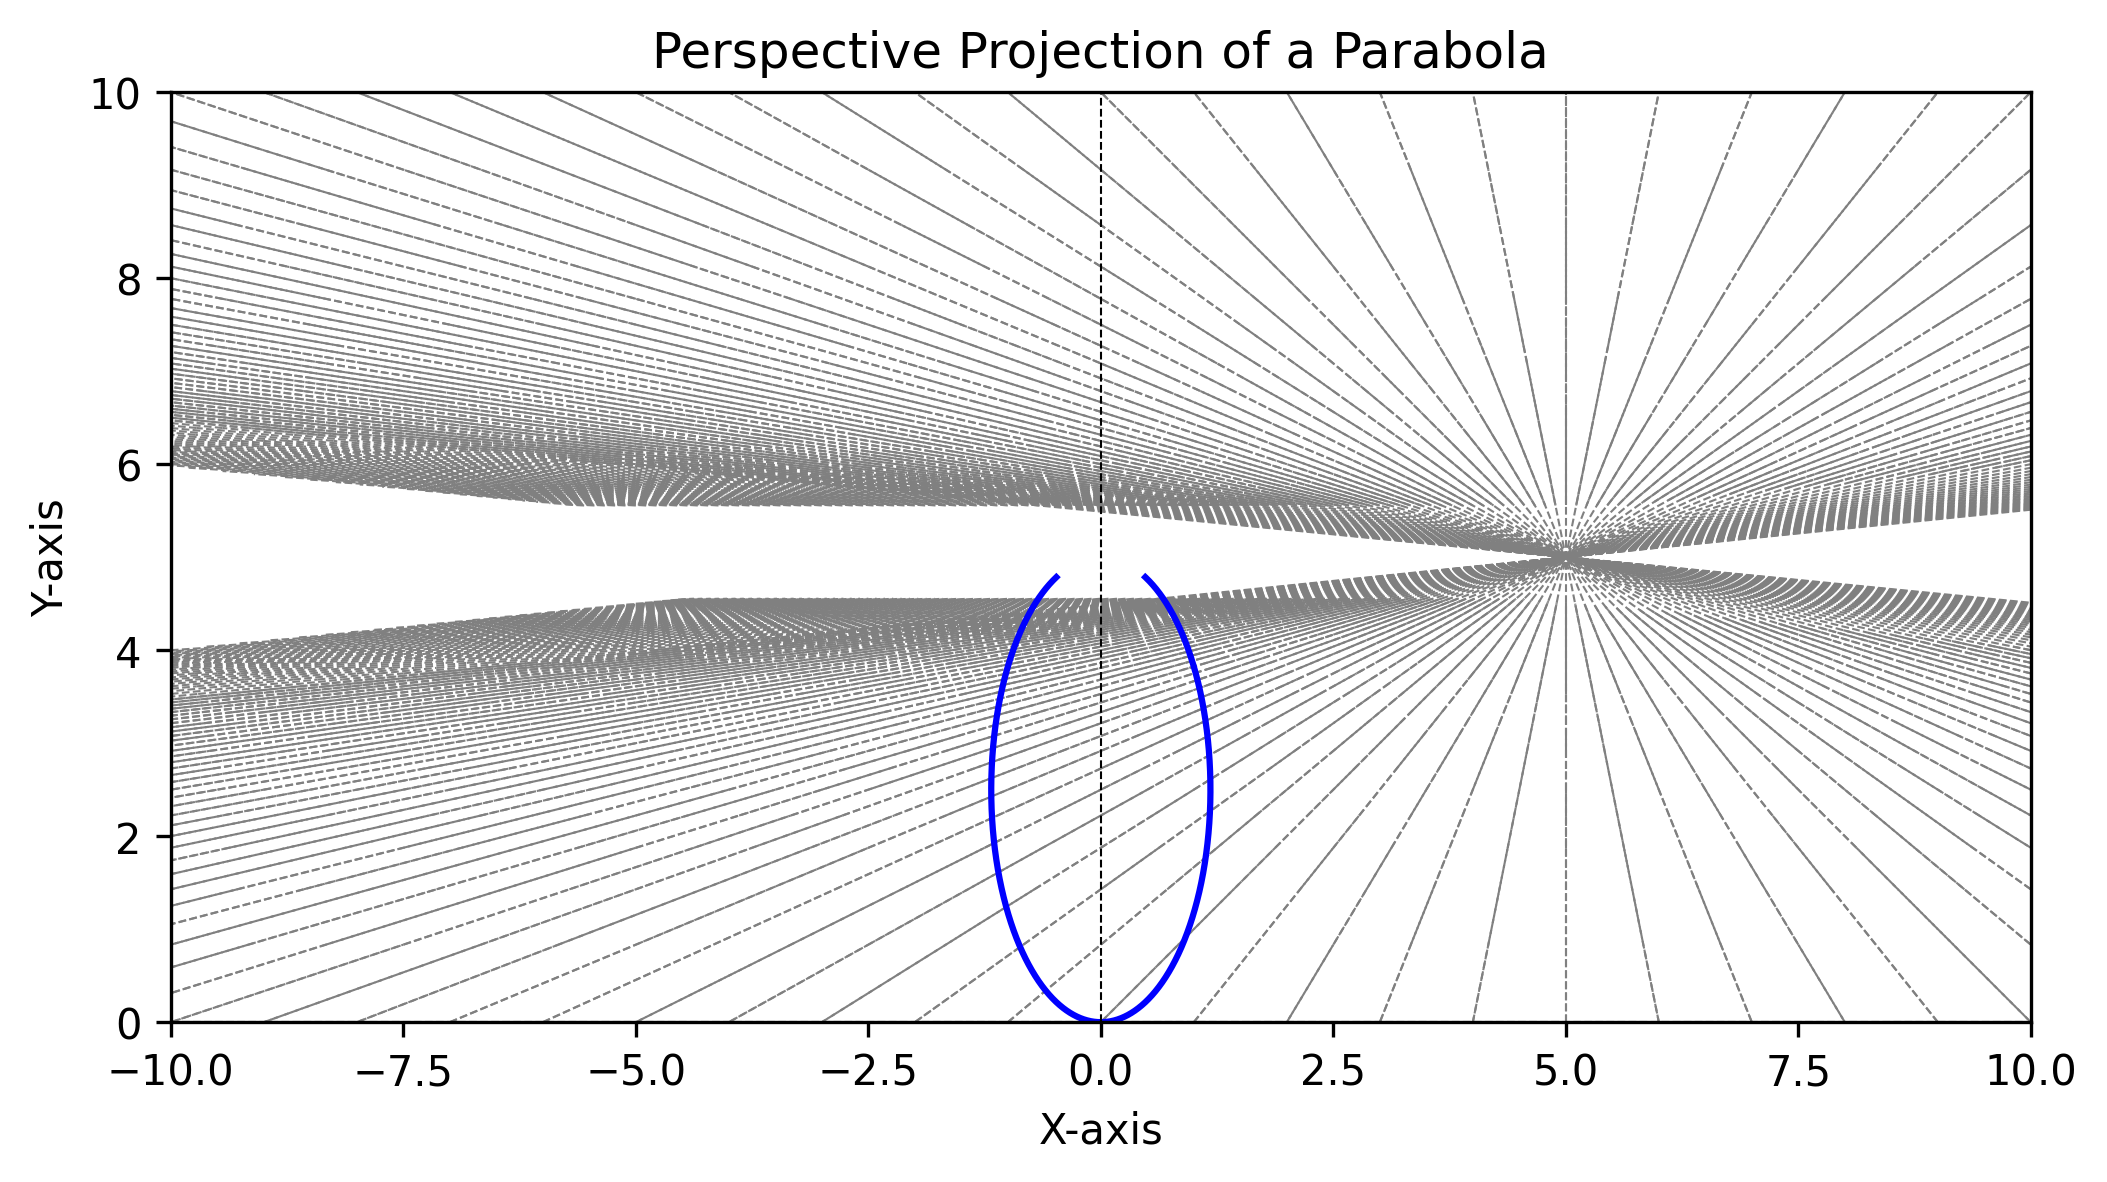

In [119]:


def create_isometric_grid(grid_density=1, grid_range=(-50, 50)):
    grid_lines = []
    for x in np.arange(grid_range[0], grid_range[1] + 1, grid_density):
        for z in np.arange(grid_range[0], grid_range[1] + 1, grid_density):
            p1 = np.array([x, z, 0])
            p2 = np.array([x + grid_density, z + grid_density, 0])
            grid_lines.append((p1, p2))
    return grid_lines


def draw_isometric_grid(ax, grid_lines, p=0, q=0.2, r=-0.1):
    for p1, p2 in grid_lines:
        # print(p1,p2, "\n")
        p1_per = perspective_projection(np.array([p1]), p, q, r) 
        p2_per = perspective_projection(np.array([p2]), p, q, r)
        # print(p1_per,p2_per, "\n")
        ax.plot([p1_per[0,0], p2_per[0,0]], [p1_per[0,1], p2_per[0,1]], 'gray', linestyle='--', lw=0.5)


def perspective_projection(points, p, q, r):
    epsilon = 1e-10
    return np.array([
    [
        point[0] / (1 + r * point[2] + p * point[0] + q * point[1] + epsilon),
        point[1] / (1 + r * point[2] + p * point[0] + q * point[1] + epsilon),
        point[2] / (1 + p * point[0] + q * point[1] + r * point[2] + epsilon)
    ]
        for point in points
    
    ])

def update(val):
    global q, r
    q = slider_q.val
    r = slider_r.val
    
p,q,r = 0, 0.2, -0.1
acc = 1 
x = np.linspace(-10*acc, 10 * acc, 10000)
y = x**2

parabola_points = np.array([[xi, yi, 1] for xi, yi in zip(x, y)])
projected_parabola = perspective_projection(parabola_points, p, q, r)

fig, ax = plt.subplots(figsize=(8, 8), dpi=300)

draw_isometric_grid(ax, create_isometric_grid(), p, q, r)
ax.plot(projected_parabola[:, 0], projected_parabola[:, 1], 'b-', label='Projected Parabola')

ax.set_xlim([-10, 10])
ax.set_ylim([0, 10])
ax.axhline(0, color='black', linewidth=0.5, ls='--')
ax.axvline(0, color='black', linewidth=0.5, ls='--')
ax.set_aspect('equal')
ax.grid(False)
ax.set_title('Perspective Projection of a Parabola')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# ax_slider_q = plt.axes([0.15, 0.1, 0.65, 0.03])
# slider_q = Slider(ax_slider_q, 'Parameter q', -1.0, 1.0, valinit=q)

# ax_slider_r = plt.axes([0.15, 0.05, 0.65, 0.03])
# slider_r = Slider(ax_slider_r, 'Parameter r', -1.0, 1.0, valinit=r)

# slider_q.on_changed(update)
# slider_r.on_changed(update)

plt.show()